### Wczytanie Bibliotek

In [2]:
from PIL import Image
import math
import sys
import numpy as np
import cv2
import tifffile
import plotly.express as px
from IPython import display
import pandas as pd
from timeit import timeit
from memory_profiler import profile
import random
from IPython.display import IFrame
import ipywidgets as widgets
import plotly
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances as pairwise_dist
import plotly.graph_objs as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
from skimage import exposure, img_as_ubyte
from ipywidgets import fixed
from matplotlib import pyplot as plt
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Wczytanie plików TIFF

Wczytanie plików Experiment-392

In [3]:
# wczytanie ścieżek do plików
file_red = 'dataset/rgb/Centr_tel Brachy/Experiment-392.czi - C=r.tif'
file_green = 'dataset/rgb/Centr_tel Brachy/Experiment-392.czi - C=g.tif'
file_blue = 'dataset/rgb/Centr_tel Brachy/Experiment-392.czi - C=b.tif'

# wczytanie plików TIFF przy użyciu biblioteki tifffile
tif_red = tifffile.imread(file_red)
tif_green = tifffile.imread(file_green)
tif_blue = tifffile.imread(file_blue)

### Wczytanie pliku Img0026-rgb.tif

In [4]:
import tifffile

# wczytanie ścieżki do pliku Image0026-rgb.tif
img26_file = 'dataset/rgb/FISH_Brachy/Image0026-rgb.tif' 

# wczytanie pliku TIFF przy użyciu biblioteki tifffile
img26 = tifffile.imread(img26_file)

# Normalizacja - zmiana głębi kolorów

Druga metoda, zflatowany tiff normalizujemy

In [5]:
tif_red_flat = tif_red.flatten()
tif_green_flat = tif_green.flatten()
tif_blue_flat = tif_blue.flatten()

In [6]:
tif_red_flat = img_as_ubyte(exposure.rescale_intensity(tif_red_flat))
tif_green_flat = img_as_ubyte(exposure.rescale_intensity(tif_green_flat))
tif_blue_flat = img_as_ubyte(exposure.rescale_intensity(tif_blue_flat))  

Trzecia metoda nie zflatowany wrzucamy do normalizacji

In [7]:
tif_red_norm = img_as_ubyte(exposure.rescale_intensity(tif_red))
tif_green_norm = img_as_ubyte(exposure.rescale_intensity(tif_green))
tif_blue_norm = img_as_ubyte(exposure.rescale_intensity(tif_blue))  

#### Metoda oryginalna normalizujemy kazdy obraz z pliku TIFF osobno

In [8]:
# przykształcenie tifów 16-bitowych na 8-bitowe

# inicjalizacja pustych tifów 8 bitowych
tif_red_norm = np.empty(shape=(18, 1040,1388), dtype='uint8')
tif_green_norm = np.empty(shape=(18, 1040,1388), dtype='uint8')
tif_blue_norm = np.empty(shape=(18, 1040,1388), dtype='uint8')

# normalizacja
for i in range(0,tif_blue.shape[0]):
    tif_red_norm[i] = img_as_ubyte(exposure.rescale_intensity(tif_red[i]))
    tif_green_norm[i] = img_as_ubyte(exposure.rescale_intensity(tif_green[i]))
    tif_blue_norm[i] = img_as_ubyte(exposure.rescale_intensity(tif_blue[i]))  

# Przekształcenie Postaci Danych

### Funkcja generująca współrzędne dla układu 4D (4D array)

In [9]:
def get_coords(tif_arr):

    z, y, x = tif_arr.shape[:3]

    x_size = x
    y_size = y
    z_size = z

    z_list = []
    for i in range(z_size):
        z_list += [i] * (y_size * x_size)

    y_list = []
    for i in range(y_size):
        y_list += [i] * (x_size)
    y_list *= z_size

    x_list = []
    x_list = np.arange(0, x_size).tolist() * (z_size * y_size)
    
    return np.c_[z_list, y_list, x_list]

Połączenie współrzędnych, kolorów i rozmiarów pixeli pliku exp-392 w jeden array 2d

In [10]:
tif_red_flat = tif_red_norm.flatten()
tif_green_flat = tif_green_norm.flatten()
tif_blue_flat = tif_blue_norm.flatten()

coords=get_coords(tif_red)

tif_arr = np.c_[coords, tif_red_flat, tif_green_flat, tif_blue_flat, np.ones((tif_red_flat.size),dtype='int32')]

### Połączenie współrzędnych, kolorów i rozmiarów pikseli

In [11]:
# zpłaszczenie danych do postaci 1D array
img26_flat = img26.flatten()

# wydobycie współrzędnych
coords=get_coords(img26)

# połączenie danych
img26_arr = np.c_[coords, img26_flat[::3], img26_flat[1::3], 
                img26_flat[2::3], np.ones((img26_flat[::3].size),dtype=int)]

In [12]:
img26_arr

array([[  0,   0,   0, ...,   0,   0,   1],
       [  0,   0,   1, ...,   0,   0,   1],
       [  0,   0,   2, ...,   0,   0,   1],
       ...,
       [ 11, 127, 127, ...,   0,   0,   1],
       [ 11, 127, 128, ...,   0,   0,   1],
       [ 11, 127, 129, ...,   0,   0,   1]])

### Usuwanie czarnego tła

In [13]:
def clear_black_bg(tif_arr, threshold):
    tif_arr = tif_arr[(tif_arr[:,3]>threshold)
                      |(tif_arr[:,4]>threshold)
                      |(tif_arr[:,5]>threshold)]
    return tif_arr

print("Rozmiar danych przed usunięciem tła",
      img26_arr.shape)

img26_arr_cl=clear_black_bg(img26_arr,80)

print("Rozmiar danych po usunięciem tła",
      img26_arr_cl.shape)

Rozmiar danych przed usunięciem tła (199680, 7)
Rozmiar danych po usunięciem tła (41562, 7)


### Histogram rozkładu nasycenia niebieskiego kanału

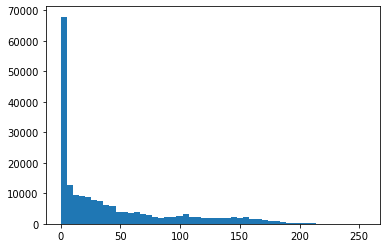

In [14]:
plt.hist(img26_arr[:,5], bins=50, range=(0,255));

Usuwanie tła pliku Img0026-rgb.tif

In [15]:
print("Rozmiar danych przed usunięciem tła",
      img26_arr.shape)

img26_arr_cl=clear_black_bg(img26_arr,80)

print("Rozmiar danych po usunięciem tła",
      img26_arr_cl.shape)

Rozmiar danych przed usunięciem tła (199680, 7)
Rozmiar danych po usunięciem tła (41562, 7)


Usuwanie tła pliku Experiment-392.tif

In [16]:
print("Rozmiar danych przed usunięciem tła",
      tif_arr.shape)

tif_arr_cl=clear_black_bg(tif_arr,80)

print("Rozmiar danych po usunięciem tła",
      tif_arr_cl.shape)

Rozmiar danych przed usunięciem tła (25983360, 7)
Rozmiar danych po usunięciem tła (616265, 7)


### funkcje pomocnicze

### Obliczanie centroidu - Python

In [17]:
def get_centroid(arr):
    length = arr.shape[0]
    sum_z = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_x = np.sum(arr[:, 2])
    sum_r = np.sum(arr[:, 3])
    sum_g = np.sum(arr[:, 4])
    sum_b = np.sum(arr[:, 5])
    return (sum_z/length, sum_y/length, sum_x/length, 
            sum_r/length, sum_g/length, sum_b/length, length)

### Obliczanie medoidu - Python

In [18]:
def get_medoid(arr):
    # tworzenie macierzy wzajemnych odległości
    distMatrix=pairwise_dist(arr[:,:6])
    # wybieranie piksela o najmniejszej sumie odległości
    medoid=arr[[np.argmin(distMatrix.sum(axis=0))]]
    # dodanie rozmiaru grupy  
    medoid[0,6]=arr.shape[0]
    
    return medoid

### Obliczanie mediany - Python

In [19]:
def get_median(arr):
    # obliczanie madian zmiennych zbioru
    median=np.median(arr,axis=0,keepdims=True)
    # zapisanie rozmiaru zbioru
    median[0,6]=arr.shape[0]

    return median

### Funkcja znajdująca sąsiadów - Python

In [20]:
def get_neighbours(arr, pixel, radius, zradius, color_diff):
    neighbours = arr[((arr[:,0]<=pixel[0]+zradius) 
                            & (arr[:,0]>=pixel[0]-zradius)
                            & (arr[:,1]<=pixel[1]+radius)
                            & (arr[:,1]>=pixel[1]-radius)
                            & (arr[:,2]<=pixel[2]+radius)
                            & (arr[:,2]>=pixel[2]-radius)
                            & (arr[:,3]<=pixel[3]+color_diff)
                            & (arr[:,3]>=pixel[3]-color_diff)
                            & (arr[:,4]<=pixel[4]+color_diff)
                            & (arr[:,4]>=pixel[4]-color_diff)
                            & (arr[:,5]<=pixel[5]+color_diff)
                            & (arr[:,5]>=pixel[5]-color_diff))]
    return neighbours

In [21]:
def get_neighbours2(arr, pixel, radius, zradius):
    neighbours = arr[((arr[:,0]<=pixel[0]+zradius) 
                            & (arr[:,0]>=pixel[0]-zradius)
                            & (arr[:,1]<=pixel[1]+radius)
                            & (arr[:,1]>=pixel[1]-radius)
                            & (arr[:,2]<=pixel[2]+radius)
                            & (arr[:,2]>=pixel[2]-radius))]
    return neighbours

In [22]:
def get_neighbours_by_color(arr, pixel, color_diff):
    neighbours = arr[((arr[:,3]<=pixel[3]+color_diff)
                            & (arr[:,3]>=pixel[3]-color_diff)
                            & (arr[:,4]<=pixel[4]+color_diff)
                            & (arr[:,4]>=pixel[4]-color_diff)
                            & (arr[:,5]<=pixel[5]+color_diff)
                            & (arr[:,5]>=pixel[5]-color_diff))]
    return neighbours

In [23]:
def cap_data(arr):
    for i in range(3,6):
        print(i)
        p1 = np.quantile(n[:,i], 0.1)
        p2 = np.quantile(n[:,i], 0.9)
        print(p1)
        print(p2)
        
        arr=arr[((arr[:,i]>=p1) & (arr[:,i]<=p2))]

    return arr

### Usuwanie podzbioru - Python

In [24]:
def remove_neighbours(neighbours_arr, tif_arr):
    dims = np.maximum(neighbours_arr.max(0),tif_arr.max(0))+1
    tif_arr = tif_arr[~np.in1d(np.ravel_multi_index(tif_arr.T,dims),
                        np.ravel_multi_index(neighbours_arr.T,dims))]
    return tif_arr

### Metoda Centroidów - wariant I - Python

In [25]:
def centroid_method(tif_arr, radius, zradius, color_diff):
    
    # utworzenie pustego zbioru centrodów
    centroids = np.empty([0,7])
    
    # zapętlanie procesu, aż zbiór danych będzie pusty
    while len(tif_arr)>0:

        # losowanie startowego piksela
        pixel = random.choice(tif_arr)

        # utworzenie zbioru sąsiadów
        neighbours_arr = get_neighbours(tif_arr, pixel, radius, zradius, color_diff)

        # obliczanie centroidu ze zbioru sąsiadów
        centroid = get_centroid(neighbours_arr)

        # dodanie centroidu do zbioru centroidów
        centroids=np.vstack([centroids, centroid])
        
        # usuń zbiór sąsiadów ze zbioru danych
        tif_arr=remove_neighbours(neighbours_arr,tif_arr)
    
    return centroids

### Metoda Centroidów - wariant II

In [26]:
def centroid_method2(tif_arr, radius, zradius, color_diff):
    # utworzenie pustego zbioru centrodów
    centroids = np.empty([0,7])
    
    # zapętlanie procesu, aż zbiór danych będzie pusty
    while len(tif_arr)>0:

         # losowanie startowego piksela
        pixel = random.choice(tif_arr)

        # wyznaczenie przestrzeni sąsiadującej na podsatawie promienia
        neighbours_arr = get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # usuwanie przestrzeni sąsiadującej ze zbioru danych
        tif_arr=remove_neighbours(neighbours_arr,tif_arr)
        
        # wyodrębnienie pikseli z opowiednią różnicą kolorów z przstrzeni sąsiadującej
        neighbours_arr = get_neighbours_by_color(neighbours_arr, pixel, color_diff)

        # obliczanie centroidu ze zbioru sąsiadów
        centroid = get_centroid(neighbours_arr)

        # dodanie centroidu do zbioru centroidów
        centroids=np.vstack([centroids, centroid])
    
    return centroids

### Metoda Centroidów - wariant III

In [27]:
def centroid_method3(tif_arr, radius, zradius):
    # utworzenie pustego zbioru centrodów
    centroids = np.empty([0,7])
    
    # zapętlanie procesu, aż zbiór danych będzie pusty
    while len(tif_arr)>0:

        # losowanie startowego piksela
        pixel = random.choice(tif_arr)

        # wyznaczenie przestrzeni sąsiadującej na podsatawie promienia
        neighbours_arr = get_neighbours2(tif_arr, pixel, radius, zradius)

        # obliczanie centroidu ze zbioru sąsiadów
        centroid = get_centroid(neighbours_arr)

        # dodanie centroidu do zbioru centroidów
        centroids=np.vstack([centroids, centroid])

        # usuwanie przestrzeni sąsiadującej ze zbioru danych
        tif_arr=remove_neighbours(neighbours_arr,tif_arr)
   
    return centroids

### Metoda I - medoid + róznica koloru + bez usuwania

In [28]:
def medoid_method(tif_arr,radius, zradius, color_diff):
    medoids = np.empty([0,7])
    # looping thorugh array until it's empty
    while len(tif_arr)>0:

        # assign starting point to random pixel         
        pixel = random.choice(tif_arr)

        # creating matrix of neighbours
        neighbours_arr = get_neighbours(tif_arr, pixel, radius, zradius, color_diff)
        
        medoid=get_medoid(neighbours_arr)
        
        medoids=np.vstack([medoids, medoid])
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=remove_neighbours(neighbours_arr,tif_arr)
        
    print(medoids.shape)
    return medoids

### Metoda II - medoid + róznica koloru + z usuwaniem

In [29]:
def medoid_method2(tif_arr,radius, zradius, color_diff):
    medoids = np.empty([0,7])
    # looping thorugh array until it's empty
    while len(tif_arr)>0:

        # assign starting point to random pixel         
        pixel = random.choice(tif_arr)

        # creating matrix of neighbours
        neighbours_arr = get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=remove_neighbours(neighbours_arr,tif_arr)
        
        neighbours_arr=get_neighbours_by_color(neighbours_arr, pixel, color_diff)

        medoid=get_medoid(neighbours_arr)
        
        medoids=np.vstack([medoids, medoid])
    print(medoids.shape)
    return medoids

### Metoda III - medoid + bez różnicy koloru + nie ma outlierów

In [30]:
def medoid_method3(tif_arr,radius, zradius):
    medoids = np.empty([0,7])
    # looping thorugh array until it's empty
    while len(tif_arr)>0:

        # assign starting point to random pixel         
        pixel = random.choice(tif_arr)

        # creating matrix of neighbours
        neighbours_arr = get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=remove_neighbours(neighbours_arr,tif_arr)

        medoid=get_medoid(neighbours_arr)
        
        medoids=np.vstack([medoids, medoid])
    print(medoids.shape)
    return medoids

### Metoda I - mediana + róznica koloru + bez usuwania

In [31]:
def median_method(tif_arr,radius, zradius, color_diff):
    medians = np.empty([0,7])
    # looping thorugh array until it's empty
    while len(tif_arr)>0:

        # assign starting point to random pixel         
        pixel = random.choice(tif_arr)

        # creating matrix of neighbours
        neighbours_arr = get_neighbours(tif_arr, pixel, radius, zradius, color_diff)
        
        median = get_median(neighbours_arr)
        
        medians=np.vstack([medians, median])
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=remove_neighbours(neighbours_arr,tif_arr)
    print(medians.shape)
    return medians

### Metoda II - mediana + róznica koloru + z usuwaniem

In [32]:
def median_method2(tif_arr,radius, zradius, color_diff):
    medians = np.empty([0,7])
    # looping thorugh array until it's empty
    while len(tif_arr)>0:

        # assign starting point to random pixel         
        pixel = random.choice(tif_arr)

        # creating matrix of neighbours
        neighbours_arr = get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=remove_neighbours(neighbours_arr,tif_arr)
        
        neighbours_arr=get_neighbours_by_color(neighbours_arr, pixel, color_diff)

        median = get_median(neighbours_arr)
        
        medians=np.vstack([medians, median])
    print(medians.shape)
    return medians

### Metoda III - mediana + bez różnicy koloru + nie ma outlierów

In [33]:
def median_method3(tif_arr,radius, zradius):
    medians = np.empty([0,7])
    # looping thorugh array until it's empty
    while len(tif_arr)>0:

        # assign starting point to random pixel         
        pixel = random.choice(tif_arr)

        # creating matrix of neighbours
        neighbours_arr = get_neighbours2(tif_arr, pixel, radius, zradius)
        
        # deleting neighbours from tif_arrlicated array
        tif_arr=remove_neighbours(neighbours_arr,tif_arr)

        median = get_median(neighbours_arr)
        
        medians=np.vstack([medians, median])
    print(medians.shape)
    return medians

### Wizualizacja w Plotly - Python

In [34]:
def plotly_vis(arr, size_min, size_max):
    # przygotowanie kolorów do wczytania do wykresu
    colors_arr = arr[:,3:6]
    colors_arr = [f'rgb({"{},{},{}".format(color[0],color[1],color[2])})' 
                  for color in colors_arr]
    
    # wykres 3d
    trace1 = go.Scatter3d(
        x=arr[:,2], 
        y=arr[:,1], 
        z=arr[:,0],
        mode="markers",
        marker_color=colors_arr,
        text=colors_arr,
        customdata=arr[:,6],
        marker=dict(
            sizemode="area",
            sizeref=arr[:,6].max() / size_max ** 2,
            sizemin=size_min,
            opacity=1,
            size=arr[:,6],
            line=dict(width=0)
        ),
        hovertemplate='<br>x:%{x}<br>y:%{y}<br>z:%{z}'
            +'<br>color: %{text}<br>size: %{customdata}'
    )

    data = [trace1]
    title = "Tiff 3D"
    layout = go.Layout(height=500, width=500, title=title)

    fig = go.Figure(data=data, layout=layout)
    fig.show()     

#### Widgety i interakcja

In [35]:
@widgets.interact_manual(
    method=['centroid_method','centroid_method2','centroid_method3',
            'medoid_method','medoid_method2','medoid_method3',
            'median_method','median_method2','median_method3'],
    tiff=fixed(img26_arr),
    threshold=widgets.IntSlider(value=100, min=30, max=150, continuous_update=False),
    radius=widgets.IntSlider(value=5, min=1, max=20, continuous_update=False), 
    zradius=widgets.IntSlider(value=2, min=1, max=5, continuous_update=False), 
    color_diff=widgets.IntSlider(value=10, min=1, max=40, continuous_update=False)
    ).options(manual_name="update")

def tif_reduction_widget(method,tiff, threshold,radius, zradius, color_diff):
    tiff=clear_black_bg(tiff, threshold)
    if method == 'centroid_method':                
        data_points = centroid_method(tiff,radius,zradius,color_diff)
    elif method == 'centroid_method2':
        data_points = centroid_method2(tiff,radius,zradius,color_diff)  
    elif method == 'centroid_method3':
        data_points = centroid_method3(tiff,radius,zradius)           
    elif method == 'medoid_method':
        data_points = medoid_method(tiff,radius,zradius,color_diff)          
    elif method == 'medoid_method2':
        data_points = medoid_method2(tiff,radius,zradius,color_diff)       
    elif method == 'medoid_method3':
        data_points = medoid_method3(tiff,radius,zradius)
    elif method == 'median_method':
        data_points = median_method(tiff,radius,zradius,color_diff)          
    elif method == 'median_method2':
        data_points = median_method2(tiff,radius,zradius,color_diff)         
    elif method == 'median_method3':
        data_points = median_method3(tiff,radius,zradius)
        
    widgets.interact(plotly_vis, arr=fixed(data_points),
                     size_min=widgets.IntSlider(
                         value=10, min=0, max=20, continuous_update=False), 
                     size_max=widgets.IntSlider(
                         value=50, min=40, max=65, continuous_update=False))

interactive(children=(Dropdown(description='method', options=('centroid_method', 'centroid_method2', 'centroid…

### Pomiary

Test metod w II wariancie

In [ ]:
img26_arr_cl.shape

In [ ]:
%timeit -r 1 centroid_method2(img26_arr_cl,1,1,10)

In [ ]:
%timeit -r 1 medoid_method2(img26_arr_cl,1,1,10)

In [ ]:
%timeit -r 1 median_method2(img26_arr_cl,1,1,10)

Test metod III wariant

In [ ]:
%timeit -r 1 centroid_method3(img26_arr_cl,1,1)

In [ ]:
%timeit -r 1 medoid_method3(img26_arr_cl,1,1)

In [ ]:
%timeit -r 1 median_method3(img26_arr_cl,1,1)

Inne testy

In [ ]:
%timeit medoid_method(img26_cl,3,1,5)

In [ ]:
%timeit medoid_method2(img26_cl,3,1,5)

In [ ]:
%timeit medoid_method3(img26_cl,3,1,5)

In [ ]:
%timeit median_method(img26_cl,3,1,5)

In [ ]:
%timeit median_method2(img26_cl,3,1,5)

In [ ]:
%memit centroid_method3(img26_cl,3,1,5)

In [ ]:
%memit medoid_method(img26_cl,5,1,10)

### Analiza porównawcza Testy

In [ ]:
%timeit centroid_method(img26_arr_cl,5,1,10)
%timeit centroid_method(img26_arr_cl,4,1,10)
%timeit centroid_method(img26_arr_cl,3,1,10)

In [ ]:
%timeit centroid_method(img26_arr_cl,5,1,5)
%timeit centroid_method(img26_arr_cl,4,1,5)
%timeit centroid_method(img26_arr_cl,3,1,5)

In [ ]:
%timeit medoid_method(img26_arr_cl,5,1,10)
%timeit medoid_method(img26_arr_cl,4,1,10)
%timeit medoid_method(img26_arr_cl,3,1,10)

In [ ]:
%timeit medoid_method(img26_arr_cl,5,1,5)
%timeit medoid_method(img26_arr_cl,4,1,5)
%timeit medoid_method(img26_arr_cl,3,1,5)

In [ ]:
%timeit median_method(img26_arr_cl,5,1,10)
%timeit median_method(img26_arr_cl,4,1,10)
%timeit median_method(img26_arr_cl,3,1,10)

In [ ]:
%timeit median_method(img26_arr_cl,5,1,5)
%timeit median_method(img26_arr_cl,4,1,5)
%timeit median_method(img26_arr_cl,3,1,5)

II

In [ ]:
%timeit centroid_method2(img26_arr_cl,3,1,10)
%timeit centroid_method2(img26_arr_cl,2,1,10)
%timeit centroid_method2(img26_arr_cl,1,1,10)

In [ ]:
%timeit centroid_method2(img26_arr_cl,3,1,1)
%timeit centroid_method2(img26_arr_cl,2,1,1)
%timeit centroid_method2(img26_arr_cl,1,1,1)

In [ ]:
%timeit medoid_method2(img26_arr_cl,3,1,10)
%timeit medoid_method2(img26_arr_cl,2,1,10)
%timeit medoid_method2(img26_arr_cl,1,1,10)
%timeit medoid_method2(img26_arr_cl,3,1,1)
%timeit medoid_method2(img26_arr_cl,2,1,1)
%timeit medoid_method2(img26_arr_cl,1,1,1)

In [ ]:
%timeit median_method2(img26_arr_cl,3,1,10)
%timeit median_method2(img26_arr_cl,2,1,10)
%timeit median_method2(img26_arr_cl,1,1,10)
%timeit median_method2(img26_arr_cl,3,1,1)
%timeit median_method2(img26_arr_cl,2,1,1)
%timeit median_method2(img26_arr_cl,1,1,1)

III

In [ ]:
%timeit centroid_method3(img26_arr_cl,3,1,10)
%timeit centroid_method3(img26_arr_cl,2,1,10)
%timeit centroid_method3(img26_arr_cl,1,1,10)
%timeit centroid_method3(img26_arr_cl,3,1,1)
%timeit centroid_method3(img26_arr_cl,2,1,1)
%timeit centroid_method3(img26_arr_cl,1,1,1)

In [ ]:
%timeit medoid_method3(img26_arr_cl,3,1,10)
%timeit medoid_method3(img26_arr_cl,2,1,10)
%timeit medoid_method3(img26_arr_cl,1,1,10)
%timeit medoid_method3(img26_arr_cl,3,1,1)
%timeit medoid_method3(img26_arr_cl,2,1,1)
%timeit medoid_method3(img26_arr_cl,1,1,1)

In [ ]:
%timeit median_method3(img26_arr_cl,3,1,10)
%timeit median_method3(img26_arr_cl,2,1,10)
%timeit median_method3(img26_arr_cl,1,1,10)
%timeit median_method3(img26_arr_cl,3,1,1)
%timeit median_method3(img26_arr_cl,2,1,1)
%timeit median_method3(img26_arr_cl,1,1,1)

### Funkcja licząca różnicę kolorów 

In [ ]:
def colorDelta(px1, px2):
    r1 = px1[3]
    g1 = px1[4]
    b1 = px1[5]

    r2 = px2[3]
    g2 = px2[4]
    b2 = px2[5]

    if (r1 == r2 & g1 == g2 & b1 == b2):
        return 0


    r = (r1 - r2)
    g = (g1 - g2)
    b = (b1 - b2)
    
    print(r,g,b)
    
    r_mean = (r1+r2)/2.
    
    diff = math.sqrt((2+r_mean/256.)*r**2+4*g**2+(2+(255.-r_mean)/256.)*b**2)

    return diff